In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import time
from random import *

#Conversions

# 1 year = 31536000 s
# 1 pc = 3.086e16 m
# 1 M_sun = 1.989e30 kg

#Some Constants Used Throughout

t_obsy = 4                  #years
t_obs = t_obsy*31536000     #s
v_t = 6.481*10**(-12)       #pc/s
d_l = 50                    #pc
d_s = 2000                  #pc
c = 9.721*10**(-9)          #pc/s
G = 4.517*10**(-30)         #pc^3/(s^2*M_sun)
sigv = 3*10**(-28)          #cm^3/s
m_chi = 100                 #GeV

Smin = []                   #The four cutoffs of Smin, in arcseconds
Smin.append(4*10**(-6))
Smin.append(16*10**(-6))
Smin.append(64*10**(-6))
Smin.append(256*10**(-6))

#Some Parameters

N_epoch = 55                #Number of Epochs
rho_0 = 2.0*10**8           #Maximum core density from dark matter annihilation (M_sun/pc^3)

N_coords = 1000
N_int = 10000
beta_twid_max = 1000
scale = d_l/(v_t*t_obs)

#m_test = 1
#Rt_test = r_t(m_test)
#Rc_test = r_c(m_test)

#Some Functions Used Throughout

def r_t(m):                                        #Truncation Radius in pc
    return (0.019*(1000/1)*(m*(1+3250))**(1/3))

def r_c(m):                                        #Core Radius in pc
    return (3.3*10**(-4)*m**(1/3))

def rho(r,m):                                      #Density in M_sun/pc^3
    if(r < r_t(m)):
        return (rho_0*(1+r/(r_c(m)))**(-9/4))
    else:
        return 0

def M2D(xi, z, Rc):                                    #M2D function
    return 4*np.pi*rho_0*(1+(np.sqrt((xi**2) + (z**2))/Rc))**(-9/4)*xi

def func(xi, Rt):                                      #Boundary function in M2D integral
    return np.sqrt(Rt**2 - xi**2)

def mass_pdf(xi, Rt):
    return 1/( (xi*np.sqrt(Rt**2 - xi**2))/2 + (Rt**2)/2*np.arcsin(xi/Rt) )

def beta_mag(by, bx):
    return np.sqrt(bx**2 + by**2)

def MC_int(xi_r, z_r, Rc, xi, Rt):
    return 1/(N_int-1)*M2D(xi_r,z_r, Rc)/mass_pdf(xi, Rt)

In [2]:
def Mass_Plot(M):  
    Rt = r_t(M)
    Rc = r_c(M)
    
    count = np.zeros(4)        #Resetting the Monte Carlo counter for successful Signals

    A_lens = np.zeros(4)       #Resetting the lensed area for successful signals

    for i in range(N_coords):
        phi = randint(0,1)/10
        beta_twid = randint(0,beta_twid_max)/10

        S_sq = 0

        for j in range(N_epoch):
            beta_y = beta_twid/scale
            beta_x = phi/scale
            beta = beta_mag(beta_y, beta_x)

            if( beta_y < Rt ) and ( beta > 0 ):
                xi = d_l*beta

                Mass_int = 0
                
                xi_rand = np.random.uniform(0, xi, N_int)
                z_rand = np.random.uniform(0, func(xi, Rt), N_int)
                
                Mass_int = np.sum(MC_int(xi_rand, z_rand, Rc, xi, Rt))
                    
                alpha = np.abs((1-d_l/d_s)*(4*G*Mass_int)/(c**2*xi))

                S_sq += alpha
                beta_x -= v_t*t_obs/N_epoch

        S = np.sqrt(S_sq)
        #print(S)
        
        count += (S > Smin)

    A_lens = (count/N_coords)*(beta_twid_max)  #Hits/Total * (b, p) area
    
    return A_lens[3],A_lens[2],A_lens[1],A_lens[0]


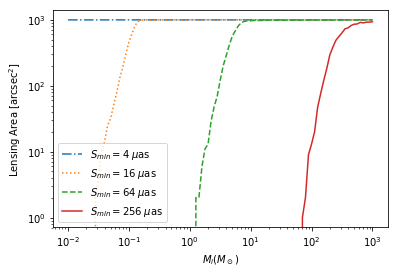

In [3]:
mass_range = np.logspace(-2,3,101)
Area_4 = np.zeros(np.size(mass_range))
Area_16 = np.zeros(np.size(mass_range))
Area_64 = np.zeros(np.size(mass_range))
Area_256 = np.zeros(np.size(mass_range))

for a in range(np.size(mass_range)):
    Area_256[a], Area_64[a], Area_16[a], Area_4[a] = Mass_Plot(mass_range[a])
    
    print("{0} remaining iterations".format(np.size(mass_range) - a), end="\r")
    
Area_4_np = np.array(Area_4)
Area_16_np = np.array(Area_16)
Area_64_np = np.array(Area_64)
Area_256_np = np.array(Area_256)


plt.plot(mass_range, Area_4, label = '$S_{min} = 4\; \mu$as', linestyle = '-.')
plt.plot(mass_range, Area_16, label = '$S_{min} = 16\; \mu$as', linestyle = ':')
plt.plot(mass_range, Area_64, label = '$S_{min} = 64\; \mu$as', linestyle = '--')
plt.plot(mass_range, Area_256, label = '$S_{min} = 256\; \mu$as')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_i(M_\odot)$')
plt.ylabel('Lensing Area [arcsec$^2$]')
plt.legend()
plt.show()

In [4]:
def h(x,y):
    return y*x**2

def pdf(x,y):
    return 1/4

N_test = 10000
I = 0
i = 0

#for i in range(N_test):
#    x = uniform(1,3)
#    y = uniform(0,x)
    
#    I += 1/(N_test-1)*h(x,y)/pdf(x,y)
    
#I

#1/scale